In [149]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, make_scorer, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
feats_dummy = pd.read_pickle(r'/Users/philliprichardson/Metis/Module 4/feats.pkl')
outcome = pd.read_pickle(r'/Users/philliprichardson/Metis/Module 4/outcome.pkl')

In [249]:
kf = StratifiedKFold(n_splits = 5, random_state = 13, shuffle = True)


def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 13)
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    score = np.mean(cross_val_score(model, X, y, cv=kf, scoring = make_scorer(recall_score, average = 'macro')))
    fitting = np.std(cross_val_score(model, X, y, cv=kf, scoring = make_scorer(recall_score, average = 'macro')))
    return score, fitting


In [179]:
kf2 = StratifiedKFold(n_splits = 3, random_state = 13, shuffle = True)

In [180]:
# Hyperparameter tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 250, num = 25)]
# Number of features to consider at every split
max_features = [3, 4, 5, 6, 7, 8, 9, 10]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7,  10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5]



In [181]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': ['balanced']}

In [239]:
randomforest_bal = RandomForestClassifier(class_weight = 'balanced')

randomforest_bal.fit(xtrain, ytrain)

rf_rand = RandomizedSearchCV(estimator = randomforest_bal, n_iter = 100, cv = kf2, random_state = 13, param_distributions = random_grid, verbose = 1, scoring = make_scorer(recall_score, average = 'weighted'))

In [192]:
rf_rand.fit(xtrain, ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=13, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      None],
                                        'max_features': [3, 4, 5, 6, 7, 8, 9,
                                                         10],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 7, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                    

In [195]:
best_rand = rf_rand.best_estimator_

recall_score(ytest, randomforest_bal.predict(xtest), average = 'weighted'), recall_score(ytest, best_rand.predict(xtest), average = 'weighted')



(0.6435931568308436, 0.6128777794211901)

In [194]:
rf_rand.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 3,
 'max_depth': 10,
 'class_weight': 'balanced',
 'bootstrap': True}

In [197]:
params= {'n_estimators': [900, 1000],
 'min_samples_split': [9, 10 , 11],
 'min_samples_leaf': [1, 2, 3],
 'max_features': [3, 4, 5],
 'max_depth': [9, 10, 11],
 'bootstrap': [True]}

In [198]:
grid_search = GridSearchCV(estimator = randomforest_bal, param_grid = params, 
                          cv = kf2, n_jobs = -1, scoring = make_scorer(recall_score, average = 'weighted'))

In [199]:
grid_search.fit(xtrain, ytrain)
best_grid= grid_search.best_estimator_

/Users/philliprichardson/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [240]:
print('BASE', '\n',classification_report(ytrain, randomforest_bal.predict(xtrain)), '\n', 'Random Search', '\n', classification_report(ytrain,  best_rand.predict(xtrain)), '\n', 'Grid Search', '\n',classification_report(ytrain,  best_grid.predict(xtrain)))

BASE 
                 precision    recall  f1-score   support

      Adoption       0.62      0.77      0.69     37412
    Euthanised       0.20      0.64      0.31      3194
Transfered/RTO       0.77      0.47      0.59     40522

      accuracy                           0.62     81128
     macro avg       0.53      0.63      0.53     81128
  weighted avg       0.68      0.62      0.62     81128
 
 Random Search 
                 precision    recall  f1-score   support

      Adoption       0.63      0.73      0.68     37412
    Euthanised       0.21      0.58      0.30      3194
Transfered/RTO       0.72      0.50      0.59     40522

      accuracy                           0.61     81128
     macro avg       0.52      0.61      0.52     81128
  weighted avg       0.66      0.61      0.62     81128
 
 Grid Search 
                 precision    recall  f1-score   support

      Adoption       0.63      0.73      0.67     37412
    Euthanised       0.71      0.06      0.11      3194


In [201]:
rf_rand_macro = RandomizedSearchCV(estimator = randomforest_bal, n_iter = 100, cv = kf2, random_state = 13, param_distributions = random_grid, verbose = 1, scoring = make_scorer(recall_score, average = 'macro'))

rf_rand_macro.fit(xtrain, ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=13, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      None],
                                        'max_features': [3, 4, 5, 6, 7, 8, 9,
                                                         10],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 7, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                    

In [202]:
rf_rand_macro.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 8,
 'max_depth': 9,
 'class_weight': 'balanced',
 'bootstrap': False}

In [205]:
best_rand_macro = rf_rand_macro.best_estimator_

recall_score(ytrain,  randomforest_bal.predict(xtrain), average = 'macro'), recall_score(ytrain,  best_rand_macro.predict(xtrain), average = 'macro')

(0.5161305934983239, 0.6089321841609803)

In [230]:
params_macro= {'n_estimators': [200, 300],
 'min_samples_split': [4,5,6],
 'min_samples_leaf': [1, 2, 3],
 'max_features': [7,8, 9],
 'max_depth': [8, 9, 10],
 'class_weight': ['balanced'],
 'bootstrap': [False]}

In [231]:
grid_search_macro = GridSearchCV(estimator = randomforest_bal, param_grid = params_macro, 
                          cv = kf2, n_jobs = -1, scoring = make_scorer(recall_score, average = 'macro'))

In [232]:
grid_search_macro.fit(xtrain, ytrain)


/Users/philliprichardson/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=13, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'class_weight': ['balanced'],
                         'max_depth': [8, 9, 10], 'max_features': [7, 8, 9],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [200, 300]},
             scoring=make_scorer(recall_score, average=macro))

In [235]:
# grid_search_macro.cv_results_
recall_score(ytrain,  randomforest_bal.predict(xtrain), average = 'macro'), recall_score(ytrain,  best_rand_macro.predict(xtrain), average = 'macro'), recall_score(ytrain,  grid_search_macro.predict(xtrain), average = 'macro')
best_grid_macro = grid_search_macro.best_estimator_

In [241]:
print('BASE', '\n',classification_report(ytrain, randomforest_bal.predict(xtrain)), '\n', 'Random Search', '\n', classification_report(ytrain,  best_rand_macro.predict(xtrain)), '\n', 'Grid Search', '\n',classification_report(ytrain,  best_grid_macro.predict(xtrain)))

BASE 
                 precision    recall  f1-score   support

      Adoption       0.62      0.77      0.69     37412
    Euthanised       0.20      0.64      0.31      3194
Transfered/RTO       0.77      0.47      0.59     40522

      accuracy                           0.62     81128
     macro avg       0.53      0.63      0.53     81128
  weighted avg       0.68      0.62      0.62     81128
 
 Random Search 
                 precision    recall  f1-score   support

      Adoption       0.61      0.78      0.69     37412
    Euthanised       0.19      0.60      0.29      3194
Transfered/RTO       0.76      0.45      0.56     40522

      accuracy                           0.61     81128
     macro avg       0.52      0.61      0.51     81128
  weighted avg       0.67      0.61      0.61     81128
 
 Grid Search 
                 precision    recall  f1-score   support

      Adoption       0.61      0.78      0.69     37412
    Euthanised       0.19      0.60      0.29      3194


In [243]:
recall_score(ytrain,  randomforest_bal.predict(xtrain), average = 'macro'), recall_score(ytrain,  best_rand_macro.predict(xtrain), average = 'macro'), recall_score(ytrain,  grid_search_macro.predict(xtrain), average = 'macro')


(0.6273121496763193, 0.6089321841609803, 0.6090155081077061)

In [247]:
print(np.mean(cross_val_score(randomforest_bal, xtrain, ytrain, cv=kf2, scoring = make_scorer(recall_score, average = 'macro'))),np.mean(cross_val_score(best_rand_macro, xtrain, ytrain, cv=kf2, scoring = make_scorer(recall_score, average = 'macro'))), 
np.mean(cross_val_score(best_grid_macro, xtrain, ytrain, cv=kf2, scoring = make_scorer(recall_score, average = 'macro'))))


0.5701733442452883 0.5974690460601023 0.5976874624586557


In [248]:
recall_score(ytest,  randomforest_bal.predict(xtest), average = 'macro'), recall_score(ytest,  best_rand_macro.predict(xtest), average = 'macro'), recall_score(ytest,  grid_search_macro.predict(xtest), average = 'macro')


(0.5819533254979122, 0.603205693731695, 0.6029973475904136)

In [267]:
feature_importance = pd.DataFrame(feats_dummy.columns).merge(pd.DataFrame(best_rand_macro.feature_importances_), left_index = True, right_index = True)

feature_importance.columns = ['Feature', 'Importance']

feature_importance.sort_values(by = 'Importance', inplace = True, ignore_index = True, ascending = False)

plot = feature_importance.iloc[:10].copy()

plot.Feature = ['Medical Issues', 'Normal Condition', 'Spayed/Neutered', 'Kitten/Puppy', 'Owner Surrendered', 'Public Assist', 'Dog/Cat', 'Neonatal', 'Stray', 'Euthanasia Request']
plot

,Feature,Importance
0,Medical Issues,0.298457
1,Normal Condition,0.233938
2,Spayed/Neutered,0.061260
3,Kitten/Puppy,0.052050
4,Owner Surrendered,0.051035
5,Public Assist,0.048111
6,Dog/Cat,0.046388
7,Neonatal,0.036177
8,Stray,0.035026
9,Euthanasia Request,0.029027


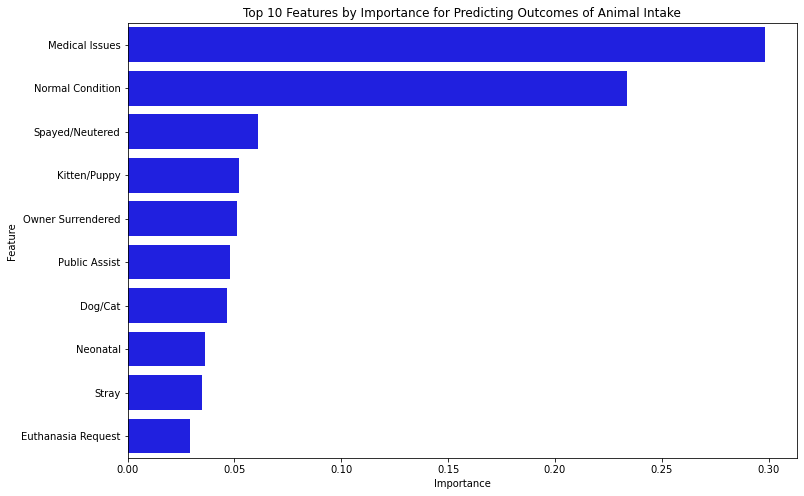

In [269]:
plt.figure(figsize=(12,8))
plt.title("Top 10 Features by Importance for Predicting Outcomes of Animal Intake")
sns.barplot(y = 'Feature', x = 'Importance', data=plot, color = 'blue');

In [254]:
arr = confusion_matrix(ytest, best_rand_macro.predict(xtest), normalize = 'true')
conf_mat = pd.DataFrame(arr, columns = ['Adoption', 'Euthanasia', 'Transfer/RTO'], index = ['Adoption', 'Euthanasia', 'Transfer/RTO'])

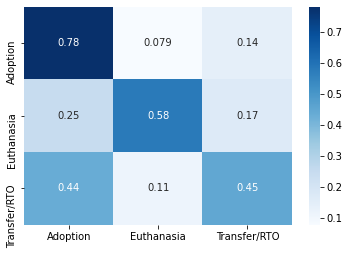

In [255]:
sns.heatmap(data = conf_mat, annot = True, cmap = 'Blues');